# 使用 DeePTB 模型结合 TBPLaS 计算材料电学性质

本教程旨在演示如何使用 `DeePTB` 训练的紧束缚模型，并将其与 `TBPLaS` 软件包相结合，用于计算材料的电学性质，例如交流电导率（AC conductivity）。

我们将展示两种常用的计算方法：
1.  **Lindhard 函数方法**：基于 Kubo-Greenwood 公式，通过在k空间中进行密集积分来计算电导率。这种方法精确但计算量较大，尤其是在密集k点网格下。
2.  **TBPM (Tight-Binding Propagation Method)**：一种线性标度的计算方法，通过时间演化来计算关联函数，从而得到材料性质。该方法对于大体系非常高效，但在小体系上反而不如直接对角化的方案高效。

---
**版本信息**
*   `tbplas`: 1.4
*   `dptb`: 2.2.1.dev18+3df7b08

**注意事项**
* DeePTB + TBPLaS 时，模型必须是正交基组
* E3模型非正交基组，不能用于 TBPLaS
* SK 模型如果从Baseline 模型出发训练，但是未做正交化处理，也无法用于 TBPLaS
---

In [ ]:
from dptb.data.build import build_dataset
from dptb.data import AtomicData
from dptb.nn import build_model
import numpy as np
import os
from ase.io import read
from dptb.postprocess.totbplas import TBPLaS
import tbplas as tb
from matplotlib import pyplot as plt
# from scipy.interpolate import  interpn
import time


# 1. Lindhard 函数方法计算交流电导率

Lindhard 函数方法是一种精确的微扰理论方法，适用于计算周期体系的线性响应性质。在这里，我们用它来计算晶体硅的交流电导率。

## 1.1. 计算设置

在这一步，我们加载 `DeePTB` 模型，读取晶体结构，并设置 `TBPLaS` 计算所需的所有参数。

In [ ]:
# --- 输入参数 ---
# DeePTB 模型文件路径
ckpt = './mix.latest.pth'
# 晶体结构文件 (VASP POSCAR 格式)
stru_data = './conv2.vasp'
# 结果保存路径
results_path = './results'
sigma = 0.05
os.makedirs(results_path, exist_ok=True)
t1 = time.process_time()
# --- 准备 DeePTB 模型和结构 ---
# 设置原子数据参数，r_max 定义了近邻原子搜索的截断半径
AtomicData_options = {"r_max": 5.1, "er_max": 5.1, "oer_max":1.6, "pbc": True}
# 调用from_ase方法，生成一个硅的AtomicData类型数据
dataset = AtomicData.from_ase(atoms=read(stru_data),**AtomicData_options)
model = build_model(ckpt)
model.eval()

# --- 转换为 TBPLaS 格式 ---
# TBPLaS 是一个辅助类，用于将 DeePTB 模型转换为 TBPLaS 可识别的 Cell 格式
tbplas = TBPLaS(model=model, device="cpu")
tbplus_atom = tbplas.get_cell(data=dataset, e_fermi=-8.104654952217583)
t2 = time.process_time()
# --- 设置 Lindhard 计算 ---
# 初始化 Lindhard 计算器
lind = tb.Lindhard(cell=tbplus_atom, 
                   energy_max=6,        # 计算的能量范围 (0 到 6 eV)
                   energy_step=600,     # 能量范围内的插值点数
                   kmesh_size=(20, 20, 20), # k点网格大小，精度关键参数
                   mu=0.0,              # 化学势 (相对于费米能级)
                   temperature=300,     # 体系温度 (K)
                   g_s=2,               # 自旋简并度
                   back_epsilon=1.0,    # 背景介电常数
                   dimension=3,         # 体系维度
                   delta=sigma          # 展宽因子
                  )

CUDA is not available. The model will be loaded on CPU.


The model option atomic_radius in nnsk is not defined in input model_options, set to v1.



Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   



## 1.2. 性质计算

调用 `calc_ac_cond` 方法执行计算。这一步是计算的核心，也是最耗时的部分，因为它需要在每个k点上对哈密顿量进行对角化以获得本征值和波函数。

In [ ]:
# 计算交流电导率，这步非常耗时
t_start = time.process_time()
omegas, ac_cond = lind.calc_ac_cond()
t_end = time.process_time()
print(f"Lindhard AC conductivity calculation time: {t_end - t_start:.2f} seconds")

## 1.3. 结果可视化
绘制交流电导率的实部和虚部随能量（光子能量）的变化关系。
- **实部 (Re[σ])**: 代表材料对电磁波的吸收。
- **虚部 (Im[σ])**: 与材料的极化性质相关。

cal AC time is  2160.0894419349997


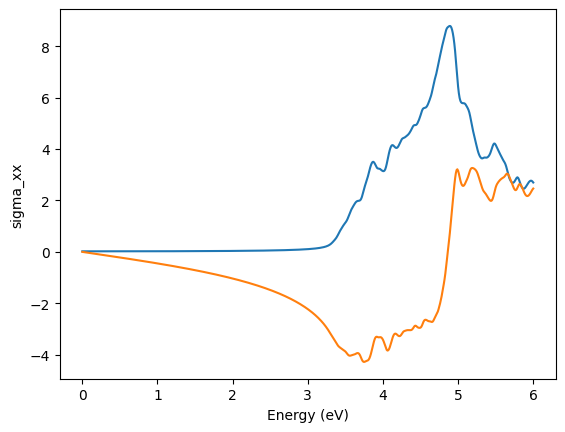

In [19]:
plt.plot(omegas, ac_cond.real, label='Re(sigma_xx)')
plt.plot(omegas, ac_cond.imag, label='Im(sigma_xx)')

plt.xlabel("Energy (eV)")
plt.ylabel("sigma_xx")
#plt.savefig("ACxx.png")
#np.save(f"{results_path}/AC_cond_sig_{sigma}.npy", {'energy':omegas, 'ACxx': ac_cond})
t3 = time.process_time()
print("cal AC time is ", t3-t2)

# 2. TBPM 方法计算交流电导率

## 2.1. 计算设置

TBPM的计算流程与 Lindhard 方法不同。这里我们需要先构建一个大的超胞（SuperCell），然后基于此进行计算。

In [ ]:
# --- 输入参数 ---
ckpt = './mix.latest.pth'
structfile = './conv2.vasp'
results_path = './results_tbpm'

os.makedirs(results_path, exist_ok=True)

# TBPM 计算参数字典
jdata = {
    "e_fermi": -8.104654952217583, # 费米能级
    "rescale_ham": 25,           # 哈密顿量重整化因子。用于将H的本征值范围缩放到[-1, 1]内。通常需要比最大本征值稍大。
    "dim": 3,                    # 体系维度
    "supercell": [5, 5, 5],      # 沿a,b,c方向构建的超胞大小
    "pbc": [True, True, True],   # 超胞的周期性边界条件
    "nsamples": 3,               # 随机矢量采样数。TBPM使用随机相位的矢量进行投影，该值越大，统计噪声越小，结果越准。
    "ntimes": 1024               # KPM展开的阶数（Chebyshev矩的数量），决定了能量分辨率。
}

# --- 准备 DeePTB 模型和结构 (同上) ---
AtomicData_options = {"r_max": 5.1, "er_max": 5.1, "oer_max":1.6, "pbc": True}
dataset = AtomicData.from_ase(atoms=read(structfile), **AtomicData_options)

model = build_model(ckpt)
model.eval()
# --- 转换为 TBPLaS 格式并构建超胞 ---
tbplas = TBPLaS(model=model, device="cpu")
tbplus_atom = tbplas.get_cell(data=dataset, e_fermi=jdata["e_fermi"])
super_cell = tb.SuperCell(tbplus_atom , dim=jdata["supercell"] , pbc=jdata["pbc"])

# 从超胞创建计算所需的 Sample 对象
sample = tb .Sample(super_cell)
# 重整化哈密顿量
if jdata["rescale_ham"] is not None:
    sample.rescale_ham(jdata["rescale_ham"])
else:
    sample.rescale_ham() # 自动寻找重整化因子

# --- 配置 TBPM 计算器 ---
config = tb.Config() 
config.generic["nr_random_samples"] = jdata['nsamples']
config.generic["nr_time_steps"] = jdata['ntimes']
#config.generic['mu'] = 0.0

config.generic['correct_spin'] = True
# config.dyn_pol['q_points'] = [[0.01, 0.01, 0.01]]  # q-points for which the dynamical polarization is calculated. for optical properties, only Gamma point is needed, q->0. small q.
config.DC_conductivity['energy_limits'] = (-5, 5)

# 创建 TBPM 的求解器 (Solver) 和分析器 (Analyzer)
solver = tb.Solver(sample, config)
analyzer = tb.Analyzer(sample, config)

CUDA is not available. The model will be loaded on CPU.
The model option atomic_radius in nnsk is not defined in input model_options, set to v1.



Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : sim_data
  Prefix     : 1762845723



## 2.2. 性质计算

使用 `solver` 计算速度-速度关联函数，然后通过 `analyzer` 进行傅里叶变换得到交流电导率。

In [ ]:
# 计算速度-速度关联函数 (correlation function for AC conductivity)
corr_ac = solver.calc_corr_ac_cond()
# 从关联函数计算交流电导率
omegas_ac, ac = analyzer.calc_ac_cond(corr_ac)

Time step for propagation:   0.041 fs

 Calculating AC conductivity correlation function.
 Sample            1  of            3
     Timestep           64  of         1024
     Timestep          128  of         1024
     Timestep          192  of         1024
     Timestep          256  of         1024
     Timestep          320  of         1024
     Timestep          384  of         1024
     Timestep          448  of         1024
     Timestep          512  of         1024
     Timestep          576  of         1024
     Timestep          640  of         1024
     Timestep          704  of         1024
     Timestep          768  of         1024
     Timestep          832  of         1024
     Timestep          896  of         1024
     Timestep          960  of         1024
     Timestep         1024  of         1024
 Sample            2  of            3
     Timestep           64  of         1024
     Timestep          128  of         1024
     Timestep          192  of         102

## 2.3. 注意事项与结果可视化

**重要提示**: 
TBPM 方法的结果精度与 `supercell` 的尺寸和 `nsamples` 的数量密切相关。
- **超胞尺寸 (`supercell`)**: 必须足够大，以消除有限尺寸效应。
- **采样数 (`nsamples`)**: 必须足够多，以降低随机采样的统计噪声。

本教程中使用的 `supercell=[5,5,5]` 和 `nsamples=3` 仅为快速演示，**其结果是不够收敛的，仅供测试流程使用**。在实际研究中，需要对这两个参数进行严格的收敛性测试。

由于随机采样的存在，原始数据会有很多噪声。我们通常使用高斯滤波对其进行平滑处理，以观察物理趋势。

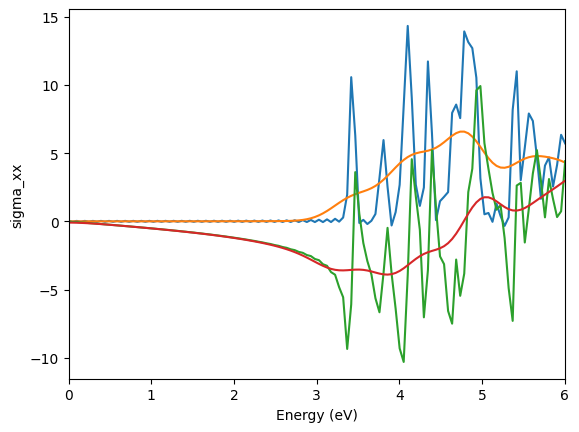

In [22]:
import scipy.ndimage
plt.plot(omegas_ac, ac[0].real)
ac_filtered = scipy.ndimage.gaussian_filter1d(ac[0].real, sigma=5)
plt.plot(omegas_ac, ac_filtered)
plt.plot(omegas_ac, ac[0].imag)
ac_filtered = scipy.ndimage.gaussian_filter1d(ac[0].imag, sigma=5)
plt.plot(omegas_ac, ac_filtered)
plt.xlabel("Energy (eV)")
plt.ylabel("sigma_xx")
plt.xlim(0, 6)
plt.show()

# 3. 总结

本教程展示了如何将 `DeePTB` 模型与 `TBPLaS` 工具结合，使用两种不同的方法计算了晶体硅的交流电导率：

1.  **Lindhard 函数方法**：在k空间计算，结果精确，但计算成本高，不适用于大体系。
2.  **TBPM 方法**：在实空间超胞上计算，是线性标度方法，适用于大体系和复杂体系，但需要仔细进行收敛性测试（超胞尺寸和采样数）。

通过本教程，你应该掌握了 `dptb` -> `tbplas` 的基本流程。你可以尝试修改 `kmesh_size` (Lindhard) 或者 `supercell`, `nsamples` (TBPM) 等参数，观察它们对计算结果和计算耗时的影响，以加深理解。